In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from scripts.utils import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from model.ANN import MLP_Model

2023-06-25 17:01:46.769880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 17:01:47.420239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-25 17:01:47.420291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-25 17:01:47.420297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import pandas as pd
import numpy as np

# Tạo DataFrame mẫu
data = {'Class A': [0.2, 0.3, 0.5],
        'Class B': [0.1, 0.6, 0.3],
        'Class C': [0.4, 0.1, 0.5]}
df = pd.DataFrame(data)

# Hàm softmax ngược
def inverse_softmax(row):
    logit = np.log(row)
    inv_softmax = np.exp(logit) / np.sum(np.exp(logit))
    return inv_softmax

# Áp dụng hàm softmax ngược cho từng hàng
df_inverse = df.apply(inverse_softmax, axis=1)

# Hiển thị DataFrame sau khi áp dụng hàm softmax ngược
print(df_inverse)


    Class A   Class B   Class C
0  0.285714  0.142857  0.571429
1  0.300000  0.600000  0.100000
2  0.384615  0.230769  0.384615


#### Using weights

In [2]:
# Init hyperparameters
epoch= 30
batch_size= 128
input_shape= (128, 128, 3)
using_class_weight= True
num_classes= 5

In [3]:
# load data
train_data, test_data= get_data('/media/data3/users/longnd/ML_prj/Data', input_shape, batch_size)
model= MLP_Model(input_shape= input_shape, num_classes= num_classes, dropout_rate=0.3)
model_path = "/media/data3/users/longnd/ML_prj/checkpoints/ann_weights.h5"
checkpoint = ModelCheckpoint(filepath= model_path,
                            save_weights_only= True,
                            monitor= 'val_accuracy',
                            save_best_only= True, verbose=1)

earlystop = EarlyStopping(monitor= 'val_accuracy', 
                          min_delta= 0.01, 
                          patience= 15,
                          verbose= 1,
                          restore_best_weights= True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

Found 10639 validated image filenames belonging to 5 classes.
Found 2662 validated image filenames belonging to 5 classes.


In [4]:
model_compiling(model)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               25166336  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896 

In [6]:
# train model
class_weight= get_balanced_weight(train_data)

if using_class_weight:
    print(class_weight)
    history = model.fit(
        train_data, 
        validation_data= test_data, 
        epochs=epoch, 
        class_weight=class_weight,
        callbacks=[earlystop, checkpoint, learning_rate_reduction])
else:
    history = model.fit(
        train_data, 
        validation_data= test_data, 
        epochs=epoch, 
        callbacks=[earlystop, checkpoint, learning_rate_reduction])

{0: 4.625652173913044, 1: 0.5233152975897688, 2: 0.6225277940315974, 3: 3.799642857142857, 4: 0.9966276346604216}
Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 3.3454 - accuracy: 0.2036 - precision: 0.2217 - recall: 0.0880 - f1_score: 0.1260
Epoch 1: val_accuracy improved from -inf to 0.32081, saving model to /media/data3/users/longnd/ML_prj/checkpoints/ann_weights.h5
84/84 [==============================] - 103s 1s/step - loss: 3.3454 - accuracy: 0.2036 - precision: 0.2217 - recall: 0.0880 - f1_score: 0.1260 - val_loss: 1.6069 - val_accuracy: 0.3208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: nan - lr: 0.0010
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 1.6263 - accuracy: 0.2394 - precision: 0.2879 - recall: 0.0018 - f1_score: 0.0035
Epoch 2: val_accuracy improved from 0.32081 to 0.32119, saving model to /media/data3/users/longnd/ML_prj/checkpoints/ann_weights.h5
84/84 [==============================] - 101s 1s/step

In [7]:
parent_dir= '/media/data3/users/longnd/ML_prj/'
# save history
save_history_to_csv(history, os.path.join(parent_dir, 'history/ann.csv'))

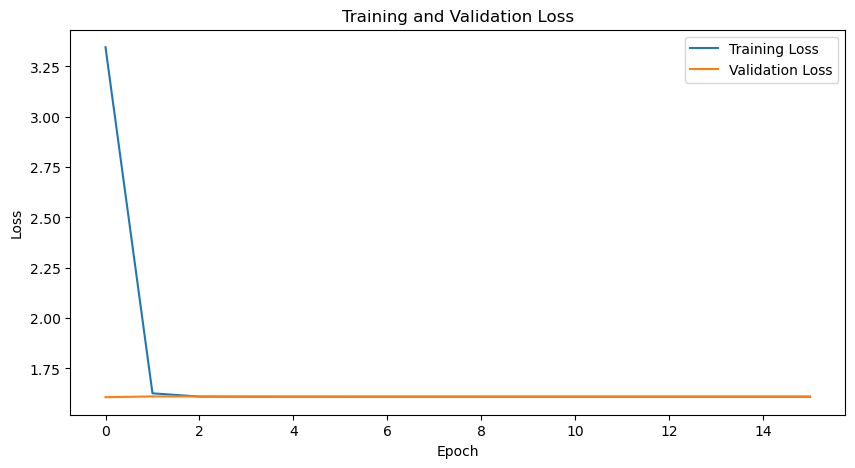

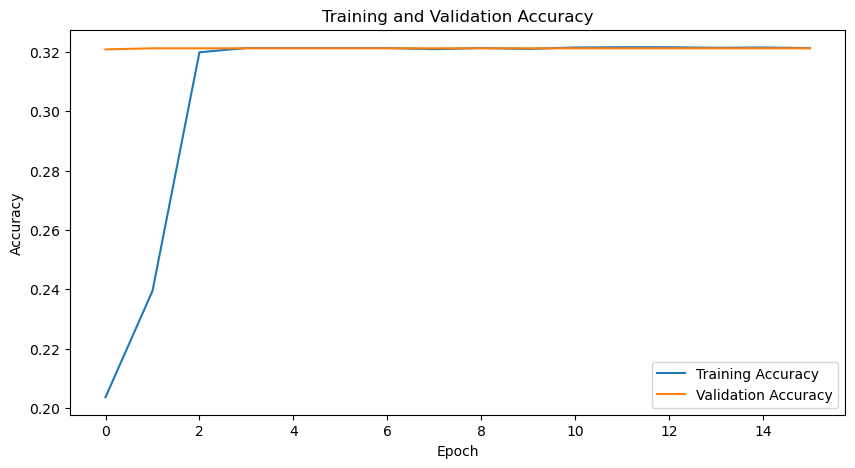

In [8]:
# plot history
plot_history(history)

In [9]:
model.evaluate(test_data)

21/21 [==============================] - 15s 731ms/step - loss: 1.6069 - accuracy: 0.3208 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: nan


[1.6068873405456543, 0.3208114206790924, 0.0, 0.0, nan]

In [10]:
# print result
get_report(model, test_data)

21/21 [==============================] - 5s 204ms/step
              precision    recall  f1-score   support

     COVID19       0.07      0.03      0.05       116
     NORMAL1       0.00      0.00      0.00      1017
   PNEUMONIA       0.33      0.99      0.49       855
TUBERCULOSIS       0.00      0.00      0.00       140
PNEUMOTHORAX       0.00      0.00      0.00       534

    accuracy                           0.32      2662
   macro avg       0.08      0.21      0.11      2662
weighted avg       0.11      0.32      0.16      2662



/media/data3/users/longnd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data3/users/longnd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/data3/users/longnd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

#### Using GAN